# Image Classification using PyTorch

In [1]:
# install: pip3 install torch torchvision matplotlib
from torchvision import datasets
from torchvision.transforms import ToTensor # turn image data to tensor

In [2]:
train_data = datasets.MNIST(root='data', train=True, transform=ToTensor(), download=True)
test_data = datasets.MNIST(root='data', train=False, transform=ToTensor(), download=True)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_data.data # gives you data with tensor

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [6]:
train_data.data.shape # grayscale in one channel

torch.Size([60000, 28, 28])

In [7]:
train_data.data.size() # same as above

torch.Size([60000, 28, 28])

In [8]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [9]:
train_data.targets.size()

torch.Size([60000])

In [10]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [11]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data, batch_size = 100, shuffle=True, num_workers=1),
    'test': DataLoader(test_data, batch_size = 100, shuffle=True, num_workers=1),
}


In [12]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1a886acf500>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1a886a73dd0>}

In [13]:
# define the model architecture
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # optimizer

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1,10, kernel_size=5) # 1 channel in, 10 channel out
        self.conv2 = nn.Conv2d(10,20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() # dropout regularization layer based on probability where some nodes are deactivated
        # fully connected layers
        self.fc1 = nn.Linear(320, 50) # dense layer
        self.fc2 = nn.Linear(50, 10) 

    # defines the forward pass of the network, which is how the input data x is processed through the layers of the network
    def forward(self, x): 
        # ReLU - rectified linear unit activation function for model linearity
        # F.relu(...): Applies the ReLU activation function to the output
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) 
        # F.max_pool2d(..., 2): Applies a 2D max pooling operation with a kernel size of 2
        x = x.view(-1, 320) # 320 = 20 x 4 x 4: reshape x to have 320 features
        x = F.relu(self.fc1(x)) # Apply a fully connected layer and ReLU activation
        x = F.dropout(x, training=self.training) # Apply dropout to prevent overfitting.
        x = self.fc2(x) # Apply another fully connected layer.
        # Convert the output to probabilities.
        return F.softmax(x, dim=1) 

### Fully Connected Layer: This layer connects every neuron in the previous layer to every neuron in the next layer.
### ReLU Activation: Introduces non-linearity to the model and helps the neural network learn more complex functions and improves its ability to generalize to new data.

In [14]:
#### The Adam optimizer is a popular optimization algorithm used in training deep learning models. It stands for Adaptive Moment Estimation.
###### Uses moving averages of the gradients and the squared gradients to provide a smoother and more stable update process.
###### Adjusts the learning rate for each parameter individually, which helps in faster convergence and better performance.

In [15]:
# the following process needs to be done manually in Torch; not in Keras
import torch

# optimize the performance of neural network training and inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Creates an instance of the CNN model and moves it to the specified device (GPU or CPU)
model = CNN().to(device)
# Initializes the Adam optimizer with the model's parameters and a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Defines the loss function as cross-entropy loss, commonly used for classification tasks.
loss_fn = nn.CrossEntropyLoss()

def train(epoch): 
    model.train() # put model in training mode
    for batch_index, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # set the gradient of each batch to zero 
        output = model(data) # Passes the input data through the model to get the output predictions.
        loss = loss_fn(output, target) # Calculates the loss between the model's predictions and the actual target values. 
        loss.backward() # Computes the gradients of the loss with respect to the model's parameters (weights) for backpropagation.
        optimizer.step() # Updates the model's parameters using the computed gradients to minimize the loss.

        '''
        # Checks if batch_index is a multiple of 20. 
        # If it is, it prints the current training epoch, the progress of the batches processed, and the current loss value.
        if batch_index % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_index * len(data)}/{len(loaders["train"].dataset)}'
      f' ({100. * batch_index / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}') '''

        # Every 20 batches, print the training progress
        if batch_index % 20 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_index}, Loss: {loss.item():.6f}')

In [19]:
def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            # finds the index of the maximum value in the output tensor along the specified dimension
            prediction = output.argmax(dim=1, keepdim=True) # ensures that the output tensor retains the same number of dimensions as the input
            # compares the predicted classes with the actual target and counts the number of correct predictions and adds this count to the cumulative
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    average_loss = test_loss
    total_samples = len(loaders['test'].dataset)
    accuracy = 100. * correct / total_samples
    
    print(f'Test Set: Average Loss: {average_loss:.4f}, Accuracy: {correct}/{total_samples} ({accuracy:.0f}%)')                                                                                                              

In [17]:
##### Batch normalization is a technique used in training deep neural networks to improve their performance and stability.
###### It normalizes the input of each layer so that they have a mean of 0 and a standard deviation of 1. 
###### This helps in stabilizing the learning process. After normalization, it scales and shifts the data using learnable parameters.

In [20]:
for epoch in range(1, 11): 
    train(epoch)
    test()

C:\Users\646ca\AppData\Local\Temp\ipykernel_27608\761587904.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch: 1, Batch: 0, Loss: 1.538422
Epoch: 1, Batch: 20, Loss: 1.651673
Epoch: 1, Batch: 40, Loss: 1.582036
Epoch: 1, Batch: 60, Loss: 1.578352
Epoch: 1, Batch: 80, Loss: 1.561228
Epoch: 1, Batch: 100, Loss: 1.612728
Epoch: 1, Batch: 120, Loss: 1.625250
Epoch: 1, Batch: 140, Loss: 1.586293
Epoch: 1, Batch: 160, Loss: 1.597601
Epoch: 1, Batch: 180, Loss: 1.553201
Epoch: 1, Batch: 200, Loss: 1.560512
Epoch: 1, Batch: 220, Loss: 1.616825
Epoch: 1, Batch: 240, Loss: 1.594082
Epoch: 1, Batch: 260, Loss: 1.571241
Epoch: 1, Batch: 280, Loss: 1.567431
Epoch: 1, Batch: 300, Loss: 1.576642
Epoch: 1, Batch: 320, Loss: 1.550215
Epoch: 1, Batch: 340, Loss: 1.569501
Epoch: 1, Batch: 360, Loss: 1.595542
Epoch: 1, Batch: 380, Loss: 1.591128
Epoch: 1, Batch: 400, Loss: 1.588434
Epoch: 1, Batch: 420, Loss: 1.574360
Epoch: 1, Batch: 440, Loss: 1.562705
Epoch: 1, Batch: 460, Loss: 1.563896
Epoch: 1, Batch: 480, Loss: 1.590219
Epoch: 1, Batch: 500, Loss: 1.557410
Epoch: 1, Batch: 520, Loss: 1.600300
Epoch: 

In [25]:
device

device(type='cpu')

In [26]:
len(test_data)

10000

Prediction: 7


C:\Users\646ca\AppData\Local\Temp\ipykernel_27608\761587904.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


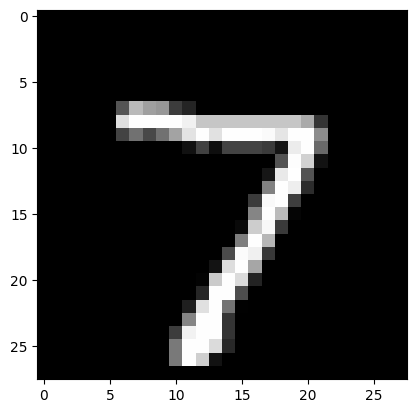

In [30]:
import matplotlib.pyplot as plt

model.eval()  # Set the model to evaluation mode

data, target = test_data[0]  # Get the first test data sample and its target

data = data.unsqueeze(0).to(device)  # Add a batch dimension and move data to the device (GPU or CPU)

output = model(data)  # Pass the data through the model to get the output predictions

prediction = output.argmax(dim=1, keepdim=True).item()  # Get the predicted class

print(f'Prediction: {prediction}')  # Print the predicted class

image = data.squeeze(0).squeeze(0).cpu().numpy()  # Remove the batch and channel dimensions, move to CPU, and convert to numpy array

plt.imshow(image, cmap='gray')  # Display the image in grayscale

plt.show()  # Show the plot